## Pattern Separation Results

In [27]:
# import necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [32]:
# add figure path
figurepath = 'C:/Users/tuq67942/OneDrive - Temple University/Documents/Figures/'
# import dfs
PSagedf = pd.read_csv('csvs/PSoutputdf_exactage.csv')
PSdf = pd.read_csv('csvs/PSoutputdf.csv')
PSdelaydf = pd.read_csv('csvs/PSdelaydf.csv')
stackeddf = pd.read_csv('csvs/PS_cat_Year_1.csv')

## Proportion selected of Target, Lure, and Foil for pattern separation
#### Stars indicate delay of 1 week between encoding and retrieval 

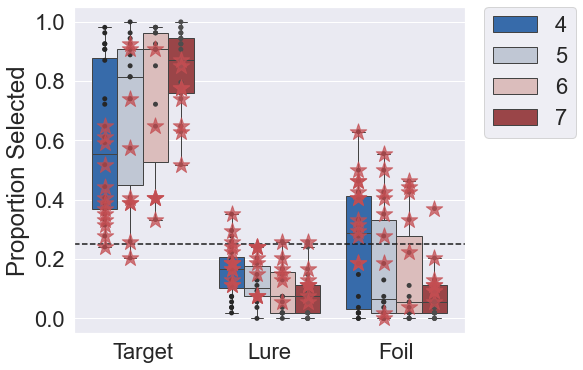

In [10]:
order = ['Target','Lure','Foil']
orderage = [4,5,6,7]

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=PSdf, x="Selection", y="Proportion Selected", hue="Age", palette="vlag",order=order, showfliers = False)
sns.stripplot(data=PSdf, x="Selection", y="Proportion Selected", hue="Age", dodge=True,palette='dark:.3',order=order, jitter=False,legend=False)
vs = {k:[] for k in orderage}
for i,points in enumerate(ax.collections):
	vertices = points.get_offsets().data
	if len(vertices)>0:
		for ii,a in enumerate([4,7,6,5]):
			if (i+ii) % 4 == 0:
				vs[a].append(vertices[0][0])
for subject in PSdelaydf.Subject.unique():
	tmp = PSdelaydf[PSdelaydf.Subject == subject]
	age = tmp['Age'].iloc[0]
	for i,selection in enumerate(order):
		data = tmp[tmp.Selection==selection]['Proportion Selected'].iloc[0]
		ax.scatter(vs[age][i],data,marker='*',color='r',alpha=0.75, s=300,zorder=3)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel=None)
plt.axhline(y=0.25, color='k', linestyle='--')
fig.savefig(figurepath+'PS_Target_Lure_Foil.png', bbox_inches='tight', dpi=100)

### Participants with 1 week delay are <i>clearly</i> off cieling, but is it significant?
### <b>Yes!</b>: Delay makes a significant difference in accuracy!

In [40]:
from pingouin import ttest
ttest(stackeddf[stackeddf['Delay']==True]['Target'],stackeddf[stackeddf['Delay']==False]['Target'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.112876,59.514289,two-sided,3.324386e-11,"[-0.42, -0.26]",1.89837,9.25e+08,1.0


# Let's just looks at those kids who had the delay going forward...

In [45]:
PSagedf = PSagedf[PSagedf['Delay']==True]
stackeddf = stackeddf[stackeddf['Delay']==True]

### plot correlation between age and Target/Lure/Foil proportion 

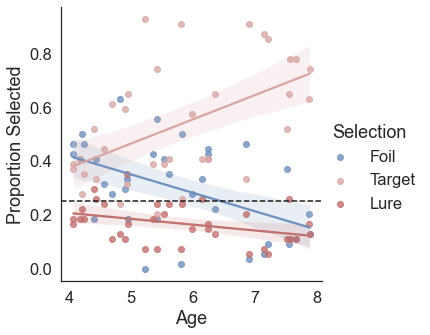

In [42]:
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
g = sns.lmplot(data=PSagedf,x="Age", y="Proportion Selected", hue="Selection")
plt.axhline(y=0.25, color='k', linestyle='--')
g.savefig(figurepath+'PS_corr_Target_Lure_Foil.png', bbox_inches='tight', dpi=100)

### Correlation between age and proportion selected of Foil, Target, and Lure:

In [43]:
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedf[PSagedf['Selection'] == selection]
	res = stats.pearsonr(tmpdf['Age'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)

,Selection,Age/Prop r,Age/Prop p
0,Foil,-0.498470,0.001974
1,Target,0.517486,0.001229
2,Lure,-0.364192,0.028989


In [62]:
import statsmodels.formula.api as sm2

result = sm2.ols(formula='Age~Foil+Target+Lure+Foil*Lure',data=stackeddf).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     4.062
Date:                Tue, 17 Oct 2023   Prob (F-statistic):             0.0149
Time:                        10:56:51   Log-Likelihood:                -52.020
No. Observations:                  36   AIC:                             112.0
Df Residuals:                      32   BIC:                             118.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7711      1.508      3.163      0.0

### Is the relationship between Lures and age significantly different from the relationship between foils and age? <b>No!</b>
### <i>Code from chatGPT4!!</i>

In [63]:
import numpy as np
from scipy.stats import t

def fisher_z_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def williams_test(r1, r2, r12, n):
    """
    Williams' Test for dependent correlations.
    
    Parameters:
    r1: First correlation coefficient.
    r2: Second correlation coefficient.
    r12: Correlation coefficient between the two variables of interest.
    n: Sample size.
    
    Returns:
    t_value: Test statistic.
    p_value: Two-tailed p-value.
    """
    
    z1 = fisher_z_transform(r1)
    z2 = fisher_z_transform(r2)
    
    numerator = z1 - z2
    denominator = np.sqrt((1 / (n - 3)) * (2 * (1 - r1) / (1 + r1) + 2 * (1 - r2) / (1 + r2) - 2 * (1 - r12)))
    
    t_value = numerator / denominator
    df = n - 3  # Degrees of freedom
    p_value = (1 - t.cdf(abs(t_value), df)) * 2  # Two-tailed p-value
    
    return t_value, p_value

t_value, p_value = williams_test(statdf[statdf.Selection=='Foil']['Age/Prop r'].iloc[0], 
              statdf[statdf.Selection=='Lure']['Age/Prop r'].iloc[0], 
              stats.pearsonr(stackeddf['Foil'],stackeddf['Lure'])[0], 
             len(stackeddf))

print(f"t-value: {t_value:.4f}")
print(f"p-value: {p_value:.4f}")

t-value: -0.3129
p-value: 0.7563


### Investigating potential differences between the selection of correct objects, locations, and animals by age:

,Selection,Age/Prop r,Age/Prop p
0,object,0.480603,0.003009
1,location,0.342111,0.041121
2,animal,0.583698,0.000186


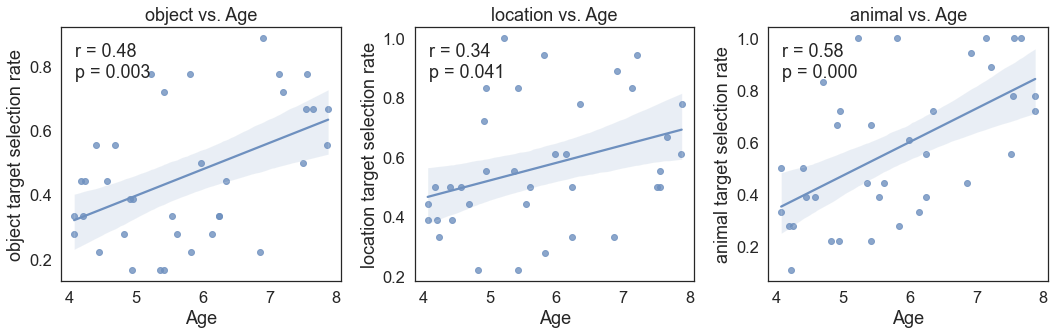

In [81]:
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,selection in enumerate(['object','location','animal']):
	res = stats.pearsonr(stackeddf['Age'],stackeddf[selection+' target selection rate'])
	statlistola.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddf, x='Age', y=selection+' target selection rate', ax=axes[i]).set_title(selection+' vs. Age')
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
statdfola=pd.DataFrame(statlistola)
display(statdfola)

plt.tight_layout()
plt.show()

### Are any of these correlation value significantly different from one another? No, although animal vs. location is trending

In [83]:
pairs = [['object','location'],['object','animal'],['animal','location']]
for pair in pairs:
    t_value, p_value = williams_test(statdfola[statdfola.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdfola[statdfola.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddf[pair[0]+' target selection rate'],
                                 stackeddf[pair[1]+' target selection rate'])[0], 
                 len(stackeddf))
    print(pair)
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

['object', 'location']
t-value: 0.9076
p-value: 0.3706
['object', 'animal']
t-value: -0.8615
p-value: 0.3952
['animal', 'location']
t-value: 1.7699
p-value: 0.0860
